In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    root = "../chap13/data", train =True, transform = transform, download = True)

test_dataset = datasets.MNIST(
    root = "../chap13/data", train =False, transform = transform, download = True)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers = 4, pin_memory = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../chap13/data/MNIST/raw/train-images-idx3-ubyte.gz to ../chap13/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../chap13/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../chap13/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../chap13/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../chap13/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../chap13/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../chap13/data/MNIST/raw



In [81]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1,8,3, stride = 2, padding =1),
            nn.ReLU(True),
            nn.Conv2d(8,16,3, stride=2, padding= 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16,32,3,stride=2,padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self,x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
            

In [82]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim,128),
            nn.ReLU(True),
            nn.Linear(128, 3* 3* 32),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size = (32,3,3))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,8,3, stride = 2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8,1,3, stride = 2, padding = 1, output_padding= 1),
        )
        
    def forward(self,x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [97]:
encoder =Encoder(encoded_space_dim= 4, fc2_input_dim= 128)
decoder = Decoder(encoded_space_dim= 4, fc2_input_dim= 128)

encoder.to(device)
decoder.to(device)

params_to_optimize = [
    {'params' : encoder.parameters(),
     'params' : decoder.parameters()}
    
]
optim = torch.optim.Adam(params_to_optimize, lr = 0.001, weight_decay = 1e-05)
loss_fn = torch.nn.MSELoss()

In [85]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor = 0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpu())
    return np.mean(train_loss)

In [86]:
def test_epoch(encoder, decoder, device, detaloader, loss_fn, optimizer, noise_factor = 0.3):
    encoder.eval()
    decoder.eval()
    train_loss = []
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [99]:
def add_noise(inputs, noise_factor = 0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0, 1)
    return noisy

In [100]:
def plot_ae_outputs(encoder, decoder, n=5, noise_factor = 0.3):
    plt.figure(figsize=(10,4.5))
    
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)
        
        encoder.eval()
        decodder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))
        plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if i == n//2:
            ax.set_title("original image")
        ax = plt.subplot(3, n, i+1, n)
        plt.impshow(image_noisy,cpu().squeeze().numpy(), cmap = 'gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('with noise image')
            
        ax = plt.subplot(3, n, i+1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap = 'gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('re organized image')
            
        plt.subplots_adjust(left = 0.1, bottom= 0.1, right = 0.7, top = 0.9, wspace = 0.3, hspace = 0.3)
        
        plt.show()

In [110]:
import matplotlib

In [166]:
import imageio
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [167]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [168]:
batch_size =512
epochs = 200
sample_size = 64
nz = 128
k = 1

In [169]:
trasnform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5,))
    
])

train_dataset = datasets.MNIST(root = '../chap13/data', train =True, transform = transform, download =True)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle =True, num_workers = 4)

In [170]:
class Generator(nn.Module):
    def __init__(self,nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,784),
            nn.Tanh(),
        )
    def forward(self,x):
        return self.main(x).view(-1,1,28,28)
    

In [177]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        x = x.view(-1,784)
        return self.main(x)
    

In [178]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [182]:
optim_g = optim.Adam(generator.parameters(), lr = 0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr = 0.0002)

#마지막이 1개의 input (node)일 경우
criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [183]:
def save_generator_image(image,path):
    save_image(image,path)

In [190]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size,1).to(device)
    fake_label = torch.zeros(b_size,1).to(device)
    optimizer.zero_grad()
    
    #real label을 1로 하는 이유는 1이 최적
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    
    #fake_label을 0으로 하는 이유는 0이 최적
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [191]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [194]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total = int(len(train_dataset)/ train_loader.batch_size)):
        image, _  = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    
    generated_img = generator(torch.randn(b_size,nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"../chap13/img/gen_img{epoch}.png")
    images.append(generated_img)
    
    epoch_loss_g = loss_g / idx
    epoch_loss_d = loss_d / idx
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Geneator loss : {epoch_loss_g:.8f}, discriminator loss : {epoch_loss_d : .8f}")

118it [00:55,  2.13it/s]                                                        

Epoch 0 of 200
Geneator loss : 0.99925256, discriminator loss :  1.33603370



118it [00:55,  2.14it/s]                                                        

Epoch 1 of 200
Geneator loss : 0.85303938, discriminator loss :  1.31786096



118it [00:55,  2.14it/s]                                                        

Epoch 2 of 200
Geneator loss : 1.55626655, discriminator loss :  1.04127800



118it [00:55,  2.14it/s]                                                        

Epoch 3 of 200
Geneator loss : 2.23322487, discriminator loss :  1.10763240



118it [00:55,  2.14it/s]                                                        


Epoch 4 of 200
Geneator loss : 1.88196683, discriminator loss :  0.97572303


118it [00:56,  2.10it/s]                                                        


Epoch 5 of 200
Geneator loss : 2.77172542, discriminator loss :  1.19226134


118it [00:56,  2.08it/s]                                                        

Epoch 6 of 200
Geneator loss : 2.06332684, discriminator loss :  0.67539191



118it [00:56,  2.10it/s]                                                        

Epoch 7 of 200
Geneator loss : 2.56545496, discriminator loss :  0.90484732



118it [00:56,  2.08it/s]                                                        


Epoch 8 of 200
Geneator loss : 2.07017159, discriminator loss :  0.96962112


118it [00:57,  2.06it/s]                                                        


Epoch 9 of 200
Geneator loss : 2.39086723, discriminator loss :  0.84022748


118it [00:57,  2.05it/s]                                                        


Epoch 10 of 200
Geneator loss : 2.54719639, discriminator loss :  0.65068132


118it [00:57,  2.04it/s]                                                        

Epoch 11 of 200
Geneator loss : 2.32750368, discriminator loss :  1.46686482



118it [00:59,  1.99it/s]                                                        

Epoch 12 of 200
Geneator loss : 2.54325080, discriminator loss :  0.72338021



118it [00:57,  2.04it/s]                                                        

Epoch 13 of 200
Geneator loss : 2.44443297, discriminator loss :  0.94648355



118it [00:57,  2.05it/s]                                                        


Epoch 14 of 200
Geneator loss : 1.62989962, discriminator loss :  0.90971351


118it [00:58,  2.02it/s]                                                        

Epoch 15 of 200
Geneator loss : 1.87096703, discriminator loss :  0.62476826



118it [00:58,  2.02it/s]                                                        


Epoch 16 of 200
Geneator loss : 2.15985465, discriminator loss :  0.78107101


118it [00:58,  2.01it/s]                                                        

Epoch 17 of 200
Geneator loss : 1.66444170, discriminator loss :  0.92252839



118it [00:58,  2.02it/s]                                                        


Epoch 18 of 200
Geneator loss : 2.28392744, discriminator loss :  0.83883852


118it [01:00,  1.97it/s]                                                        

Epoch 19 of 200
Geneator loss : 1.69514740, discriminator loss :  0.95884961



118it [00:59,  1.99it/s]                                                        


Epoch 20 of 200
Geneator loss : 1.67355812, discriminator loss :  0.85369945


118it [00:58,  2.03it/s]                                                        

Epoch 21 of 200
Geneator loss : 1.81317580, discriminator loss :  0.93110913



118it [00:58,  2.03it/s]                                                        


Epoch 22 of 200
Geneator loss : 1.84761989, discriminator loss :  0.81858480


118it [00:57,  2.05it/s]                                                        

Epoch 23 of 200
Geneator loss : 1.72224879, discriminator loss :  0.79855597



118it [00:57,  2.05it/s]                                                        

Epoch 24 of 200
Geneator loss : 2.06653333, discriminator loss :  0.83849782



118it [00:57,  2.05it/s]                                                        

Epoch 25 of 200
Geneator loss : 1.97124362, discriminator loss :  0.78241915



118it [00:57,  2.06it/s]                                                        

Epoch 26 of 200
Geneator loss : 1.79863107, discriminator loss :  0.92369139



118it [00:58,  2.03it/s]                                                        

Epoch 27 of 200
Geneator loss : 1.74234676, discriminator loss :  0.85278261



118it [00:57,  2.05it/s]                                                        

Epoch 28 of 200
Geneator loss : 1.76727700, discriminator loss :  0.79884011



118it [00:59,  1.97it/s]                                                        

Epoch 29 of 200
Geneator loss : 1.93858933, discriminator loss :  0.82903075



118it [00:59,  1.99it/s]                                                        

Epoch 30 of 200
Geneator loss : 2.09254599, discriminator loss :  0.79944074



118it [00:59,  2.00it/s]                                                        

Epoch 31 of 200
Geneator loss : 1.62646234, discriminator loss :  0.87834060



118it [00:59,  1.99it/s]                                                        

Epoch 32 of 200
Geneator loss : 1.98193228, discriminator loss :  0.76781857



118it [00:59,  1.97it/s]                                                        

Epoch 33 of 200
Geneator loss : 2.08313727, discriminator loss :  0.79073006



118it [00:59,  1.99it/s]                                                        

Epoch 34 of 200
Geneator loss : 1.55759835, discriminator loss :  0.88030756



118it [00:58,  2.01it/s]                                                        

Epoch 35 of 200
Geneator loss : 2.03802013, discriminator loss :  0.74375415



118it [00:58,  2.03it/s]                                                        


Epoch 36 of 200
Geneator loss : 2.06735420, discriminator loss :  0.72299010


118it [00:57,  2.04it/s]                                                        

Epoch 37 of 200
Geneator loss : 2.11477613, discriminator loss :  0.90805638



118it [00:57,  2.05it/s]                                                        

Epoch 38 of 200
Geneator loss : 1.92833281, discriminator loss :  0.81749260



118it [00:57,  2.05it/s]                                                        

Epoch 39 of 200
Geneator loss : 2.04330420, discriminator loss :  0.92666185



118it [00:57,  2.04it/s]                                                        

Epoch 40 of 200
Geneator loss : 2.22701740, discriminator loss :  0.92523587



118it [00:57,  2.05it/s]                                                        

Epoch 41 of 200
Geneator loss : 2.44131160, discriminator loss :  1.01092625



118it [00:58,  2.00it/s]                                                        


Epoch 42 of 200
Geneator loss : 1.88249063, discriminator loss :  1.04181540


118it [00:59,  1.98it/s]                                                        


Epoch 43 of 200
Geneator loss : 1.82590401, discriminator loss :  0.98278195


118it [00:59,  1.99it/s]                                                        

Epoch 44 of 200
Geneator loss : 1.68486547, discriminator loss :  1.09453201



118it [00:59,  1.99it/s]                                                        

Epoch 45 of 200
Geneator loss : 1.81079412, discriminator loss :  0.89183271



118it [00:58,  2.01it/s]                                                        

Epoch 46 of 200
Geneator loss : 1.53606045, discriminator loss :  1.01198959



118it [00:58,  2.01it/s]                                                        

Epoch 47 of 200
Geneator loss : 1.95900023, discriminator loss :  0.99795485



118it [00:59,  1.99it/s]                                                        

Epoch 48 of 200
Geneator loss : 1.57194912, discriminator loss :  1.02110744



118it [00:59,  1.99it/s]                                                        

Epoch 49 of 200
Geneator loss : 1.96356344, discriminator loss :  1.10939991



118it [00:58,  2.03it/s]                                                        

Epoch 50 of 200
Geneator loss : 2.14309359, discriminator loss :  1.12753141



118it [00:57,  2.05it/s]                                                        

Epoch 51 of 200
Geneator loss : 1.56231678, discriminator loss :  0.99211866



118it [00:57,  2.04it/s]                                                        


Epoch 52 of 200
Geneator loss : 1.72063112, discriminator loss :  0.94171375


118it [01:00,  1.96it/s]                                                        

Epoch 53 of 200
Geneator loss : 1.36065996, discriminator loss :  1.06655896



118it [00:59,  1.97it/s]                                                        

Epoch 54 of 200
Geneator loss : 1.51089895, discriminator loss :  0.77850193



118it [00:59,  1.98it/s]                                                        

Epoch 55 of 200
Geneator loss : 1.60981238, discriminator loss :  1.09380996



118it [00:59,  1.97it/s]                                                        


Epoch 56 of 200
Geneator loss : 2.13611341, discriminator loss :  0.99308223


118it [00:59,  1.98it/s]                                                        

Epoch 57 of 200
Geneator loss : 1.51475275, discriminator loss :  0.98456621



118it [01:00,  1.96it/s]                                                        

Epoch 58 of 200
Geneator loss : 2.06185269, discriminator loss :  1.06412244



118it [00:58,  2.01it/s]                                                        

Epoch 59 of 200
Geneator loss : 1.75955606, discriminator loss :  0.95717025



118it [00:58,  2.00it/s]                                                        


Epoch 60 of 200
Geneator loss : 1.62944841, discriminator loss :  1.07899904


118it [01:13,  1.60it/s]                                                        

Epoch 61 of 200
Geneator loss : 1.62313199, discriminator loss :  1.03347230



118it [01:06,  1.77it/s]                                                        

Epoch 62 of 200
Geneator loss : 1.67408204, discriminator loss :  0.77878898



118it [01:01,  1.93it/s]                                                        

Epoch 63 of 200
Geneator loss : 1.46919107, discriminator loss :  1.10735452



118it [01:00,  1.95it/s]                                                        

Epoch 64 of 200
Geneator loss : 1.42040300, discriminator loss :  0.98893541



118it [01:00,  1.94it/s]                                                        

Epoch 65 of 200
Geneator loss : 1.46280098, discriminator loss :  0.91723448



118it [01:01,  1.93it/s]                                                        

Epoch 66 of 200
Geneator loss : 1.52998471, discriminator loss :  0.99169219



118it [01:01,  1.93it/s]                                                        

Epoch 67 of 200
Geneator loss : 1.34574640, discriminator loss :  0.97507012



118it [01:00,  1.94it/s]                                                        

Epoch 68 of 200
Geneator loss : 1.64431846, discriminator loss :  1.01397777



118it [01:02,  1.89it/s]                                                        

Epoch 69 of 200
Geneator loss : 1.65703034, discriminator loss :  0.91631472



118it [01:01,  1.90it/s]                                                        

Epoch 70 of 200
Geneator loss : 1.74872136, discriminator loss :  1.02639556



118it [00:59,  1.97it/s]                                                        

Epoch 71 of 200
Geneator loss : 1.72490716, discriminator loss :  0.90137589



118it [00:58,  2.00it/s]                                                        


Epoch 72 of 200
Geneator loss : 1.72177792, discriminator loss :  0.96754873


118it [00:58,  2.02it/s]                                                        

Epoch 73 of 200
Geneator loss : 1.61902106, discriminator loss :  1.11600602



118it [00:58,  2.02it/s]                                                        

Epoch 74 of 200
Geneator loss : 1.85219085, discriminator loss :  0.86750937



118it [00:58,  2.01it/s]                                                        

Epoch 75 of 200
Geneator loss : 1.64863861, discriminator loss :  0.95518833



118it [00:58,  2.02it/s]                                                        

Epoch 76 of 200
Geneator loss : 1.59006882, discriminator loss :  1.00514519



118it [00:58,  2.02it/s]                                                        

Epoch 77 of 200
Geneator loss : 1.70304048, discriminator loss :  1.03393197



118it [00:58,  2.02it/s]                                                        


Epoch 78 of 200
Geneator loss : 1.67625070, discriminator loss :  1.06917381


118it [00:58,  2.03it/s]                                                        

Epoch 79 of 200
Geneator loss : 1.61359334, discriminator loss :  1.00583684



118it [00:58,  2.02it/s]                                                        


Epoch 80 of 200
Geneator loss : 1.52473915, discriminator loss :  1.02029598


118it [00:58,  2.02it/s]                                                        

Epoch 81 of 200
Geneator loss : 1.68988574, discriminator loss :  1.00835884



118it [00:58,  2.03it/s]                                                        


Epoch 82 of 200
Geneator loss : 1.63804185, discriminator loss :  1.09393251


118it [00:58,  2.03it/s]                                                        


Epoch 83 of 200
Geneator loss : 1.49081290, discriminator loss :  1.09288299


118it [00:58,  2.03it/s]                                                        

Epoch 84 of 200
Geneator loss : 1.47297812, discriminator loss :  1.09587157



118it [00:58,  2.03it/s]                                                        

Epoch 85 of 200
Geneator loss : 1.28483522, discriminator loss :  1.10882664



118it [00:58,  2.02it/s]                                                        

Epoch 86 of 200
Geneator loss : 1.75071669, discriminator loss :  1.01179659



118it [00:58,  2.02it/s]                                                        

Epoch 87 of 200
Geneator loss : 1.90643311, discriminator loss :  1.09040987



118it [00:58,  2.03it/s]                                                        


Epoch 88 of 200
Geneator loss : 1.46779346, discriminator loss :  1.13051522


118it [00:58,  2.03it/s]                                                        


Epoch 89 of 200
Geneator loss : 1.94663310, discriminator loss :  0.93883085


118it [00:58,  2.02it/s]                                                        


Epoch 90 of 200
Geneator loss : 1.33046341, discriminator loss :  1.13997626


118it [00:58,  2.03it/s]                                                        


Epoch 91 of 200
Geneator loss : 1.40138102, discriminator loss :  0.98968929


118it [00:58,  2.02it/s]                                                        


Epoch 92 of 200
Geneator loss : 1.52630675, discriminator loss :  0.93066043


118it [00:58,  2.03it/s]                                                        

Epoch 93 of 200
Geneator loss : 1.50982845, discriminator loss :  0.92610061



118it [00:58,  2.03it/s]                                                        

Epoch 94 of 200
Geneator loss : 1.40477574, discriminator loss :  1.00537419



118it [00:59,  1.98it/s]                                                        

Epoch 95 of 200
Geneator loss : 1.54223657, discriminator loss :  0.98733795



118it [01:01,  1.93it/s]                                                        

Epoch 96 of 200
Geneator loss : 1.70876944, discriminator loss :  0.87827080



118it [00:59,  1.98it/s]                                                        

Epoch 97 of 200
Geneator loss : 1.70226896, discriminator loss :  1.00158286



118it [00:59,  1.99it/s]                                                        

Epoch 98 of 200
Geneator loss : 1.54654026, discriminator loss :  1.04899859



118it [01:01,  1.93it/s]                                                        

Epoch 99 of 200
Geneator loss : 1.97937298, discriminator loss :  1.03480589



118it [01:02,  1.89it/s]                                                        

Epoch 100 of 200
Geneator loss : 1.68835950, discriminator loss :  0.98231763



118it [01:02,  1.89it/s]                                                        

Epoch 101 of 200
Geneator loss : 1.38078952, discriminator loss :  0.95082563



118it [01:01,  1.93it/s]                                                        

Epoch 102 of 200
Geneator loss : 1.46712315, discriminator loss :  0.98136973



118it [01:00,  1.94it/s]                                                        

Epoch 103 of 200
Geneator loss : 1.76627898, discriminator loss :  0.87136269



118it [01:00,  1.96it/s]                                                        

Epoch 104 of 200
Geneator loss : 1.55453813, discriminator loss :  0.96634328



118it [00:59,  1.98it/s]                                                        

Epoch 105 of 200
Geneator loss : 1.51040649, discriminator loss :  0.93741602



118it [01:05,  1.81it/s]                                                        

Epoch 106 of 200
Geneator loss : 1.55735147, discriminator loss :  0.93404180



118it [00:58,  2.00it/s]                                                        


Epoch 107 of 200
Geneator loss : 1.93234098, discriminator loss :  0.90546989


118it [00:59,  1.99it/s]                                                        

Epoch 108 of 200
Geneator loss : 1.75866389, discriminator loss :  1.07012260



118it [00:58,  2.00it/s]                                                        

Epoch 109 of 200
Geneator loss : 1.42659259, discriminator loss :  0.93047202



118it [00:59,  2.00it/s]                                                        

Epoch 110 of 200
Geneator loss : 1.53132772, discriminator loss :  1.05841649



118it [00:59,  1.99it/s]                                                        

Epoch 111 of 200
Geneator loss : 1.42936134, discriminator loss :  0.93518633



118it [00:59,  1.99it/s]                                                        

Epoch 112 of 200
Geneator loss : 1.38728642, discriminator loss :  1.06547546



118it [00:59,  2.00it/s]                                                        

Epoch 113 of 200
Geneator loss : 1.71823418, discriminator loss :  1.03987408



118it [01:16,  1.53it/s]                                                        

Epoch 114 of 200
Geneator loss : 1.70978665, discriminator loss :  0.91368037



118it [01:08,  1.72it/s]                                                        

Epoch 115 of 200
Geneator loss : 1.89988148, discriminator loss :  0.85672373



118it [01:01,  1.91it/s]                                                        

Epoch 116 of 200
Geneator loss : 1.43272936, discriminator loss :  0.99869877



118it [01:01,  1.92it/s]                                                        

Epoch 117 of 200
Geneator loss : 1.69820046, discriminator loss :  0.93755484



118it [01:00,  1.95it/s]                                                        

Epoch 118 of 200
Geneator loss : 1.83104622, discriminator loss :  0.92358756



118it [00:59,  1.98it/s]                                                        


Epoch 119 of 200
Geneator loss : 1.73768198, discriminator loss :  0.92053080


118it [00:59,  1.97it/s]                                                        

Epoch 120 of 200
Geneator loss : 1.94287503, discriminator loss :  0.99311107



118it [01:05,  1.79it/s]                                                        

Epoch 121 of 200
Geneator loss : 2.13447022, discriminator loss :  0.91730011



118it [01:02,  1.89it/s]                                                        

Epoch 122 of 200
Geneator loss : 2.61734438, discriminator loss :  0.85287005



118it [01:00,  1.94it/s]                                                        


Epoch 123 of 200
Geneator loss : 1.80094159, discriminator loss :  0.93881166


118it [01:00,  1.97it/s]                                                        

Epoch 124 of 200
Geneator loss : 1.61121678, discriminator loss :  0.87809062



118it [00:59,  1.97it/s]                                                        


Epoch 125 of 200
Geneator loss : 1.64852214, discriminator loss :  1.00496542


118it [01:00,  1.94it/s]                                                        


Epoch 126 of 200
Geneator loss : 1.88312089, discriminator loss :  0.85387784


118it [01:01,  1.93it/s]                                                        


Epoch 127 of 200
Geneator loss : 1.53383577, discriminator loss :  0.92645931


118it [01:01,  1.92it/s]                                                        


Epoch 128 of 200
Geneator loss : 1.85213518, discriminator loss :  0.90658897


118it [01:00,  1.94it/s]                                                        

Epoch 129 of 200
Geneator loss : 1.37527156, discriminator loss :  1.00017369



118it [01:00,  1.96it/s]                                                        


Epoch 130 of 200
Geneator loss : 1.67927909, discriminator loss :  0.87034345


118it [00:59,  1.97it/s]                                                        


Epoch 131 of 200
Geneator loss : 1.59891033, discriminator loss :  0.95710319


118it [01:00,  1.96it/s]                                                        


Epoch 132 of 200
Geneator loss : 1.70291305, discriminator loss :  0.94351685


118it [01:01,  1.93it/s]                                                        

Epoch 133 of 200
Geneator loss : 1.87046254, discriminator loss :  0.83730537



118it [01:01,  1.93it/s]                                                        

Epoch 134 of 200
Geneator loss : 1.76275158, discriminator loss :  0.98084414



118it [01:01,  1.91it/s]                                                        

Epoch 135 of 200
Geneator loss : 1.95731151, discriminator loss :  0.98244834



118it [01:00,  1.94it/s]                                                        

Epoch 136 of 200
Geneator loss : 2.15047956, discriminator loss :  0.77775973



118it [01:01,  1.92it/s]                                                        

Epoch 137 of 200
Geneator loss : 1.90528584, discriminator loss :  0.93400717



118it [01:00,  1.95it/s]                                                        

Epoch 138 of 200
Geneator loss : 1.98345089, discriminator loss :  0.83883941



118it [01:00,  1.94it/s]                                                        

Epoch 139 of 200
Geneator loss : 1.86077571, discriminator loss :  0.95697939



118it [01:00,  1.96it/s]                                                        


Epoch 140 of 200
Geneator loss : 1.80756998, discriminator loss :  0.81683540


118it [01:00,  1.96it/s]                                                        

Epoch 141 of 200
Geneator loss : 1.74354100, discriminator loss :  0.89116335



118it [01:00,  1.94it/s]                                                        

Epoch 142 of 200
Geneator loss : 1.83457136, discriminator loss :  0.80893713



118it [01:04,  1.82it/s]                                                        

Epoch 143 of 200
Geneator loss : 1.66859424, discriminator loss :  0.87168396



118it [01:03,  1.86it/s]                                                        

Epoch 144 of 200
Geneator loss : 1.63501620, discriminator loss :  0.97151649



118it [01:00,  1.95it/s]                                                        


Epoch 145 of 200
Geneator loss : 1.88508213, discriminator loss :  0.85561562


118it [01:00,  1.96it/s]                                                        


Epoch 146 of 200
Geneator loss : 1.95227528, discriminator loss :  0.85770923


118it [01:00,  1.94it/s]                                                        

Epoch 147 of 200
Geneator loss : 1.83685577, discriminator loss :  0.96952891



118it [01:02,  1.89it/s]                                                        

Epoch 148 of 200
Geneator loss : 1.57293808, discriminator loss :  0.95399749



118it [01:00,  1.96it/s]                                                        

Epoch 149 of 200
Geneator loss : 1.99109828, discriminator loss :  0.91072851



118it [01:00,  1.94it/s]                                                        

Epoch 150 of 200
Geneator loss : 2.10634708, discriminator loss :  0.79889822



118it [01:01,  1.92it/s]                                                        

Epoch 151 of 200
Geneator loss : 1.78852677, discriminator loss :  0.78412253



118it [01:00,  1.96it/s]                                                        

Epoch 152 of 200
Geneator loss : 1.92459428, discriminator loss :  0.81470269



118it [01:03,  1.86it/s]                                                        

Epoch 153 of 200
Geneator loss : 1.92992473, discriminator loss :  0.89486700



118it [01:02,  1.87it/s]                                                        

Epoch 154 of 200
Geneator loss : 1.80981493, discriminator loss :  0.79433680



118it [00:58,  2.00it/s]                                                        


Epoch 155 of 200
Geneator loss : 1.72024417, discriminator loss :  0.95263737


118it [00:59,  2.00it/s]                                                        

Epoch 156 of 200
Geneator loss : 1.80527866, discriminator loss :  0.78776580



118it [00:58,  2.02it/s]                                                        


Epoch 157 of 200
Geneator loss : 1.71380389, discriminator loss :  0.89138955


118it [00:59,  2.00it/s]                                                        

Epoch 158 of 200
Geneator loss : 1.99193251, discriminator loss :  0.84501189



118it [00:59,  1.98it/s]                                                        

Epoch 159 of 200
Geneator loss : 2.00197697, discriminator loss :  0.85405648



118it [01:02,  1.90it/s]                                                        

Epoch 160 of 200
Geneator loss : 1.78948843, discriminator loss :  0.82763094



118it [01:00,  1.96it/s]                                                        

Epoch 161 of 200
Geneator loss : 1.65642953, discriminator loss :  0.96898800



118it [01:00,  1.95it/s]                                                        

Epoch 162 of 200
Geneator loss : 1.99199760, discriminator loss :  0.82898939



118it [00:59,  1.99it/s]                                                        

Epoch 163 of 200
Geneator loss : 1.99226785, discriminator loss :  0.84724545



118it [00:58,  2.00it/s]                                                        

Epoch 164 of 200
Geneator loss : 1.86317849, discriminator loss :  0.83121729



118it [01:00,  1.96it/s]                                                        

Epoch 165 of 200
Geneator loss : 2.14085650, discriminator loss :  0.78770852



118it [01:00,  1.96it/s]                                                        

Epoch 166 of 200
Geneator loss : 1.88743186, discriminator loss :  0.89242733



118it [01:00,  1.95it/s]                                                        

Epoch 167 of 200
Geneator loss : 2.21342778, discriminator loss :  0.87440449



118it [01:00,  1.96it/s]                                                        

Epoch 168 of 200
Geneator loss : 2.43562937, discriminator loss :  0.79188412



118it [01:01,  1.91it/s]                                                        

Epoch 169 of 200
Geneator loss : 1.86006939, discriminator loss :  0.88356459



118it [01:01,  1.93it/s]                                                        

Epoch 170 of 200
Geneator loss : 1.91174912, discriminator loss :  0.83600003



118it [01:05,  1.80it/s]                                                        

Epoch 171 of 200
Geneator loss : 2.22322106, discriminator loss :  0.84185696



118it [01:02,  1.89it/s]                                                        

Epoch 172 of 200
Geneator loss : 2.09200692, discriminator loss :  0.81978387



118it [01:01,  1.92it/s]                                                        

Epoch 173 of 200
Geneator loss : 1.82875657, discriminator loss :  0.76288116



118it [00:59,  1.97it/s]                                                        

Epoch 174 of 200
Geneator loss : 2.26389766, discriminator loss :  0.82718778



118it [00:59,  1.98it/s]                                                        

Epoch 175 of 200
Geneator loss : 1.93463826, discriminator loss :  0.86599743



118it [01:01,  1.92it/s]                                                        

Epoch 176 of 200
Geneator loss : 2.07947493, discriminator loss :  0.82047641



118it [01:00,  1.94it/s]                                                        

Epoch 177 of 200
Geneator loss : 2.16930628, discriminator loss :  0.80649924



118it [01:00,  1.95it/s]                                                        

Epoch 178 of 200
Geneator loss : 1.97712827, discriminator loss :  0.85847688



118it [01:00,  1.95it/s]                                                        

Epoch 179 of 200
Geneator loss : 1.87198591, discriminator loss :  0.83657634



118it [01:03,  1.87it/s]                                                        

Epoch 180 of 200
Geneator loss : 2.10351896, discriminator loss :  0.76561230



118it [01:00,  1.93it/s]                                                        

Epoch 181 of 200
Geneator loss : 2.01830101, discriminator loss :  0.78332222



118it [01:03,  1.85it/s]                                                        

Epoch 182 of 200
Geneator loss : 2.09216285, discriminator loss :  0.67941123



118it [01:03,  1.86it/s]                                                        

Epoch 183 of 200
Geneator loss : 1.90126920, discriminator loss :  0.80184126



118it [01:01,  1.93it/s]                                                        

Epoch 184 of 200
Geneator loss : 2.10860348, discriminator loss :  0.79518771



118it [01:00,  1.94it/s]                                                        

Epoch 185 of 200
Geneator loss : 2.36500072, discriminator loss :  0.71039039



118it [01:01,  1.92it/s]                                                        

Epoch 186 of 200
Geneator loss : 2.51549196, discriminator loss :  0.81609976



118it [01:01,  1.93it/s]                                                        

Epoch 187 of 200
Geneator loss : 2.18057156, discriminator loss :  0.80607146



118it [01:00,  1.94it/s]                                                        

Epoch 188 of 200
Geneator loss : 2.18111658, discriminator loss :  0.83363509



118it [01:01,  1.91it/s]                                                        

Epoch 189 of 200
Geneator loss : 2.33204150, discriminator loss :  0.72536325



118it [01:01,  1.91it/s]                                                        


Epoch 190 of 200
Geneator loss : 2.04657841, discriminator loss :  0.78655082


118it [01:00,  1.95it/s]                                                        

Epoch 191 of 200
Geneator loss : 1.98170924, discriminator loss :  0.76505572



118it [01:02,  1.90it/s]                                                        

Epoch 192 of 200
Geneator loss : 1.95685863, discriminator loss :  0.77353239



118it [01:01,  1.93it/s]                                                        

Epoch 193 of 200
Geneator loss : 2.17181516, discriminator loss :  0.74969900



118it [01:00,  1.93it/s]                                                        

Epoch 194 of 200
Geneator loss : 2.29352427, discriminator loss :  0.78723747



118it [01:01,  1.92it/s]                                                        

Epoch 195 of 200
Geneator loss : 1.87031496, discriminator loss :  0.73184663



118it [01:00,  1.95it/s]                                                        

Epoch 196 of 200
Geneator loss : 2.09681249, discriminator loss :  0.81795996



118it [01:00,  1.95it/s]                                                        

Epoch 197 of 200
Geneator loss : 2.24236274, discriminator loss :  0.70414454



118it [01:00,  1.95it/s]                                                        


Epoch 198 of 200
Geneator loss : 2.06081295, discriminator loss :  0.76544726


118it [01:01,  1.93it/s]                                                        


Epoch 199 of 200
Geneator loss : 2.16242361, discriminator loss :  0.73420399


In [203]:
losses_g

[0.9992525577545166,
 0.8530393838882446,
 1.5562665462493896,
 2.233224868774414,
 1.8819668292999268,
 2.7717254161834717,
 2.063326835632324,
 2.5654549598693848,
 2.070171594619751,
 2.390867233276367,
 2.547196388244629,
 2.3275036811828613,
 2.543250799179077,
 2.4444329738616943,
 1.6298996210098267,
 1.8709670305252075,
 2.1598546504974365,
 1.664441704750061,
 2.2839274406433105,
 1.6951473951339722,
 1.6735581159591675,
 1.8131757974624634,
 1.847619891166687,
 1.7222487926483154,
 2.066533327102661,
 1.9712436199188232,
 1.7986310720443726,
 1.7423467636108398,
 1.7672770023345947,
 1.938589334487915,
 2.092545986175537,
 1.6264623403549194,
 1.981932282447815,
 2.083137273788452,
 1.557598352432251,
 2.038020133972168,
 2.067354202270508,
 2.114776134490967,
 1.928332805633545,
 2.043304204940796,
 2.227017402648926,
 2.4413115978240967,
 1.882490634918213,
 1.8259040117263794,
 1.6848654747009277,
 1.8107941150665283,
 1.5360604524612427,
 1.9590002298355103,
 1.5719491243

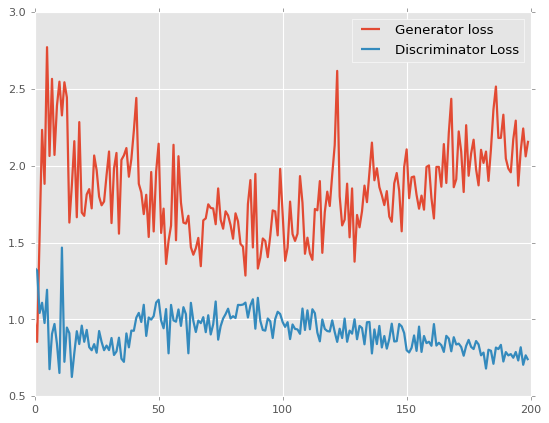

In [205]:
plt.figure()
#losses_g = [f.item() for f1 in losses_g]
plt.plot(losses_g, label = 'Generator loss')
#losses_d = [f2.item() for f2 in losses_d]
plt.plot(losses_d, label = "Discriminator Loss")
plt.legend()

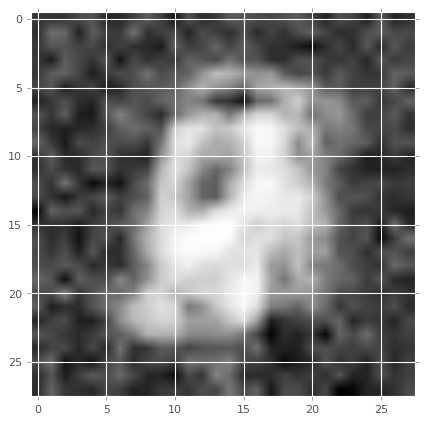

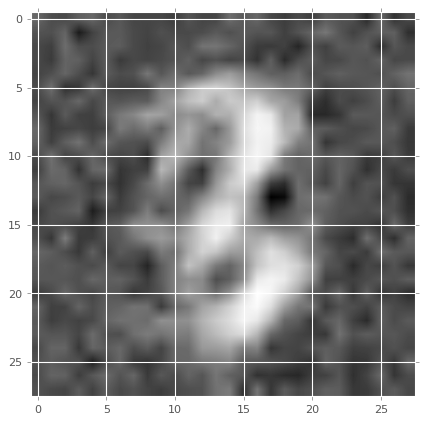

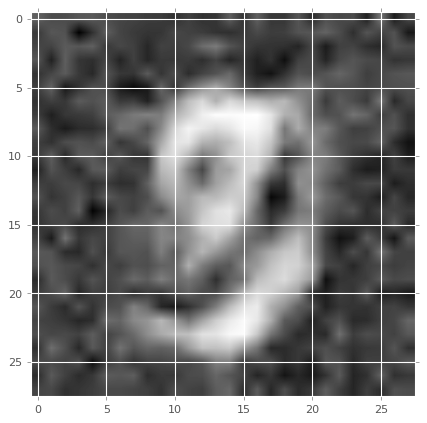

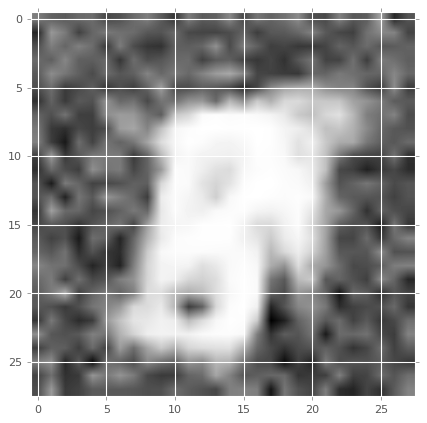

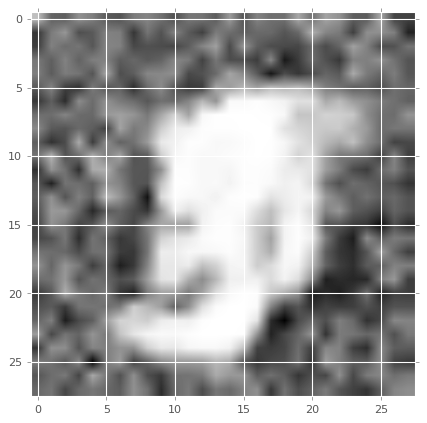

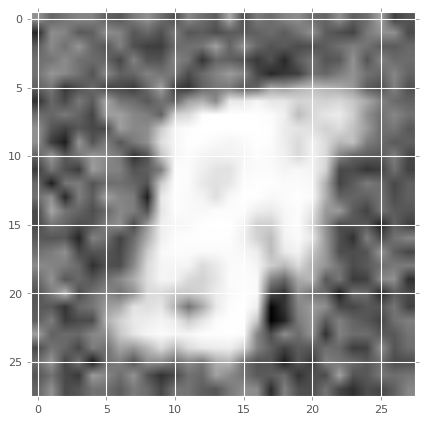

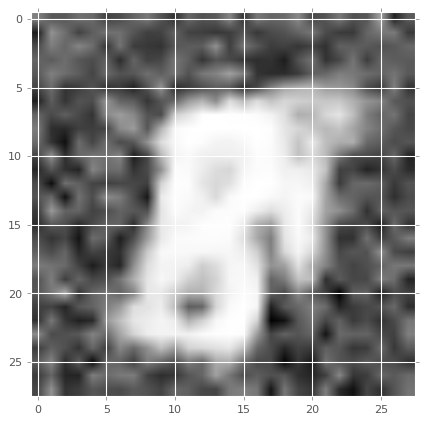

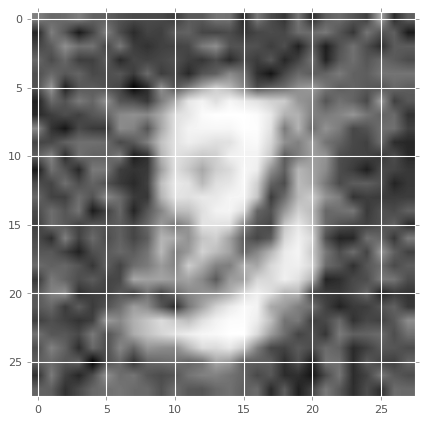

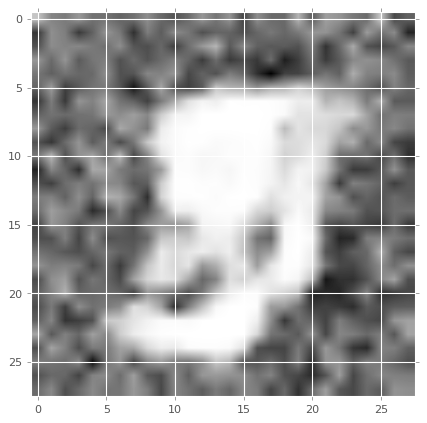

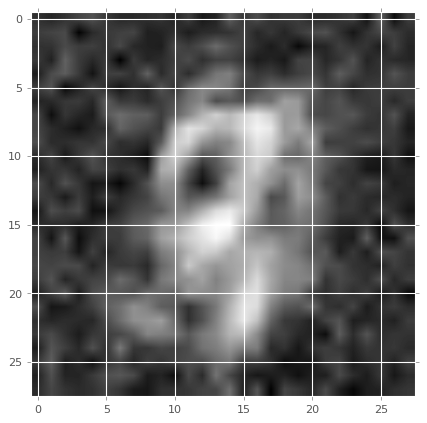

In [206]:
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28,28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.savefig('../chap13/img/fake_images_img' + str(i) + '.png')
    plt.show()